In [68]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [69]:
df = pd.read_csv(r"C:\Users\AMOS PC\Downloads\Telegram Desktop\marketing_campaign.csv",
                sep='\t',
                header=0)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [71]:
df = df.dropna()

In [72]:
#Feature Engineering
df = df.copy()

#Age of customer today 
df.loc[:, "Age"] = 2025 - df["Year_Birth"]

# Total children
df.loc[:, "Total_Children"] = df["Kidhome"] + df["Teenhome"]

# List of columns to sum
purchase_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Total spending across purchase columns
df.loc[:, "Total_Spending"] = df[purchase_cols].sum(axis=1)

#Deriving living situation by marital status"Alone"
df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", 
                                                "Together":"Partner", 
                                                "Absurd":"Alone", 
                                                "Widow":"Alone", 
                                                "YOLO":"Alone", 
                                                "Divorced":"Alone", 
                                                "Single":"Alone",})

# Family size (fixing future warning and using .loc)
df.loc[:, "Family_Size"] = (
    df["Living_With"]
    .replace({"Alone": 1, "Partner": 2})
    .astype(int)
    + df["Total_Children"]
)

# Simplify marital status into Living_With
df.loc[:, "Living_With"] = df["Marital_Status"].replace({
    "Married": "Partner",
    "Together": "Partner",
    "Divorced": "Alone",
    "Widow": "Alone",
    "Alone": "Alone",
    "YOLO": "Alone"
})

#Feature pertaining parenthood
df.loc[:, "Is_Parent"] = np.where(df.Total_Children > 0, 1, 0)

# Clean Education categories
df.loc[:, "Education"] = df["Education"].replace({"Basic": "Undergraduate"})


In [73]:
df = df.drop(['Year_Birth', 'Kidhome', 'Teenhome', 'ID', 'Marital_Status', 'Z_Revenue',
              'Dt_Customer', 'Z_CostContact', 'MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], axis=1)  # Example

In [74]:
df.head()

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Total_Children,Total_Spending,Living_With,Family_Size,Is_Parent
0,Graduation,58138.0,58,3,8,10,4,7,0,0,...,0,0,0,1,68,0,1617,Single,1,0
1,Graduation,46344.0,38,2,1,1,2,5,0,0,...,0,0,0,0,71,2,27,Single,3,1
2,Graduation,71613.0,26,1,8,2,10,4,0,0,...,0,0,0,0,60,0,776,Partner,2,0
3,Graduation,26646.0,26,2,2,0,4,6,0,0,...,0,0,0,0,41,1,53,Partner,3,1
4,PhD,58293.0,94,5,5,3,6,5,0,0,...,0,0,0,0,44,1,422,Partner,3,1


In [75]:
df.dtypes

Education               object
Income                 float64
Recency                  int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
Age                      int64
Total_Children           int64
Total_Spending           int64
Living_With             object
Family_Size              int64
Is_Parent                int32
dtype: object

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

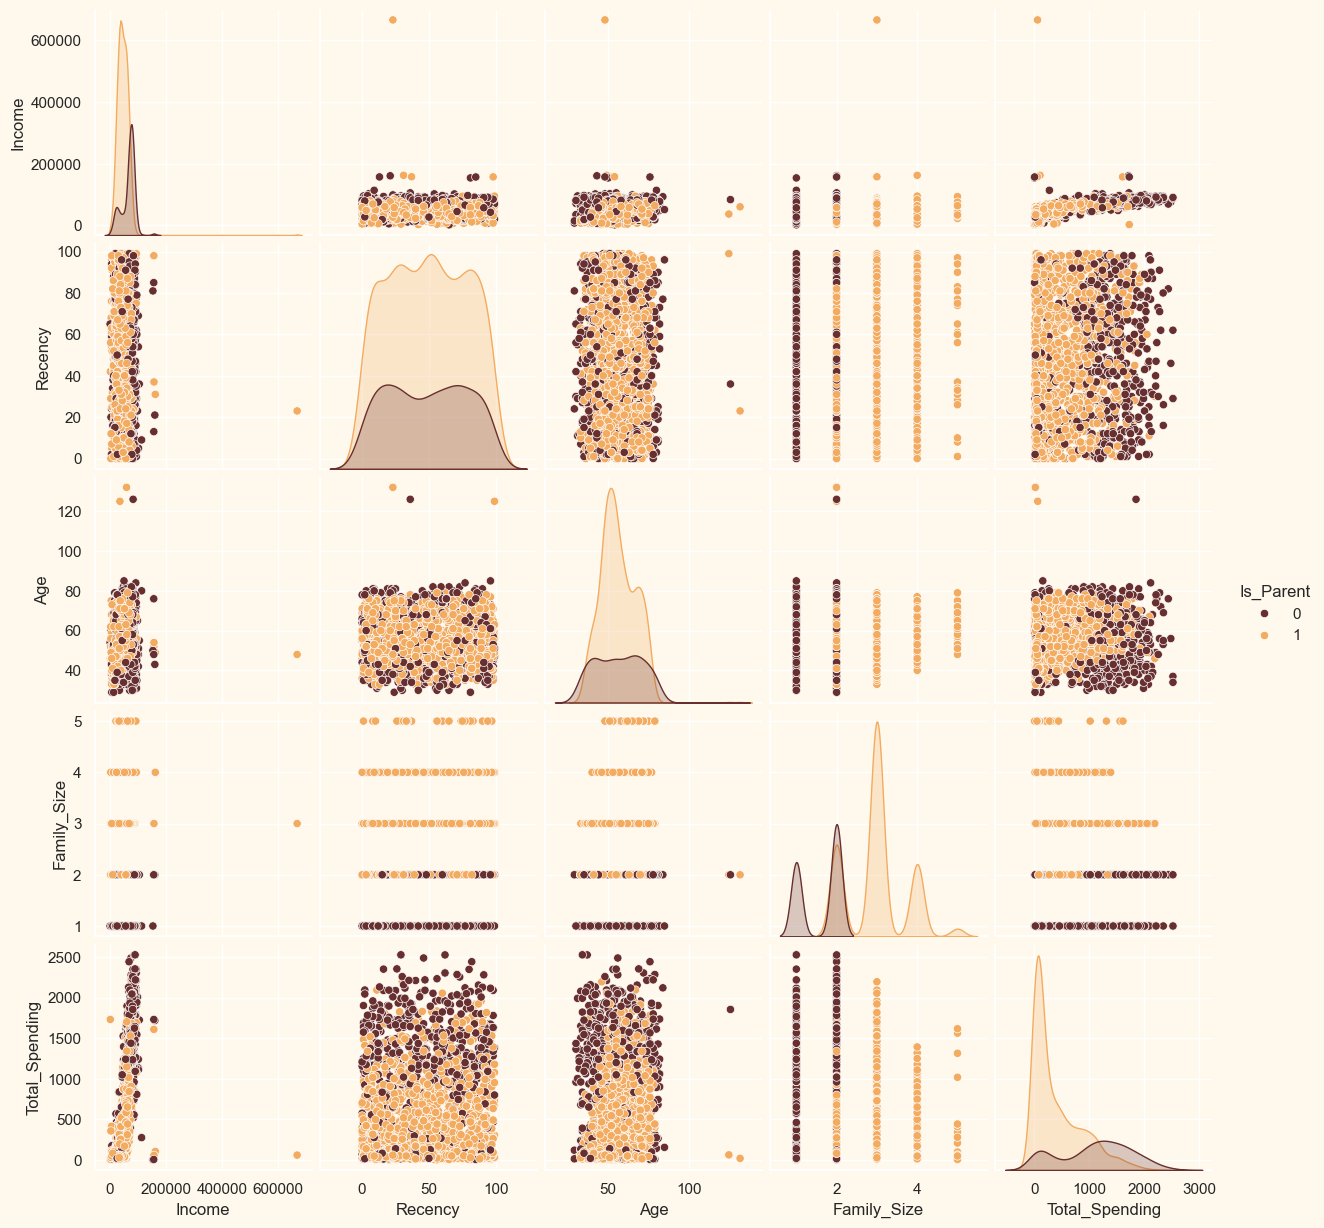

In [76]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Age", "Is_Parent", "Education", "Family_Size", "Total_Spending"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [77]:
#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2212


In [78]:
enc = LabelEncoder()
columns_to_encode = ['Education', 'Living_With']
for column in columns_to_encode:
    df[column] = pd.factorize(df[column])[0]

In [79]:
#Creating a copy of data
ds = df.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response', 
            ]
ds = ds.drop(cols_del, axis=1)

In [80]:
ds.head()

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Total_Children,Total_Spending,Living_With,Family_Size,Is_Parent
0,0,58138.0,58,3,8,10,4,7,68,0,1617,0,1,0
1,0,46344.0,38,2,1,1,2,5,71,2,27,0,3,1
2,0,71613.0,26,1,8,2,10,4,60,0,776,1,2,0
3,0,26646.0,26,2,2,0,4,6,41,1,53,1,3,1
4,1,58293.0,94,5,5,3,6,5,44,1,422,1,3,1


In [81]:
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [82]:
pca = PCA().fit(scaled_ds)  # Compute all PCs
print("Variance explained by each PC:", pca.explained_variance_ratio_)

Variance explained by each PC: [0.34926976 0.1539049  0.08156593 0.07388967 0.06952962 0.06542262
 0.05681075 0.04109594 0.03238541 0.02263061 0.02070746 0.01553834
 0.00934509 0.00790389]


In [83]:
pca = PCA(n_components=0.90)  # retain 90% of variance
X_reduced = pca.fit_transform(scaled_ds)
print(f"Number of PCs selected: {pca.n_components_}")
print(f"Explained variance: {sum(pca.explained_variance_ratio_):.2%}")

Number of PCs selected: 9
Explained variance: 92.39%


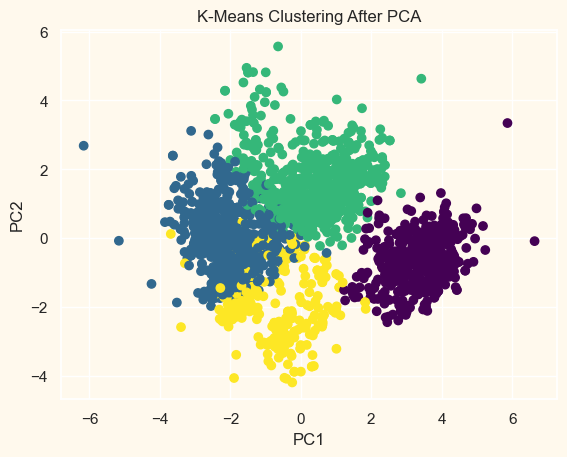

In [109]:
# Choose number of clusters (e.g., using the Elbow Method)
kmeans = KMeans(n_clusters=4, random_state=42)  
clusters = kmeans.fit_predict(X_reduced)

# Plot clusters (if 2D/3D)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clustering After PCA")
plt.savefig('k-means clustering after PCA.png')  # Save as PNG
plt.show()

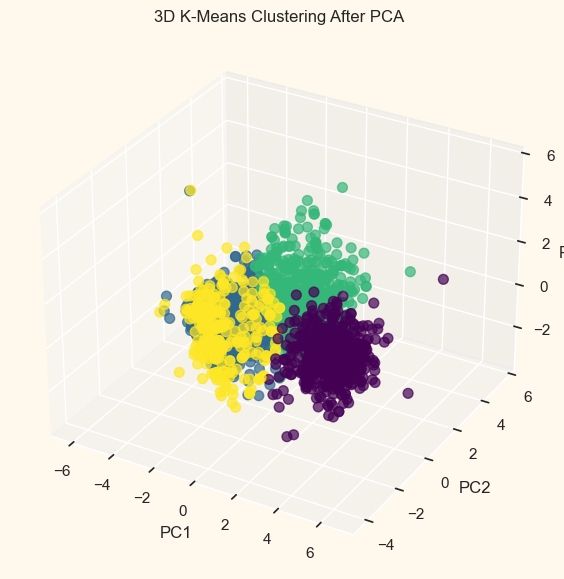

In [110]:
# Run KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
    c=clusters, cmap='viridis', s=50, alpha=0.7
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D K-Means Clustering After PCA")
plt.savefig('3D k-means clustering after PCA.png')  # Save as PNG
plt.show()

In [86]:
# Check Cluster Distribution.
unique, counts = np.unique(clusters, return_counts=True)
print(f"Cluster distribution: {dict(zip(unique, counts))}")

Cluster distribution: {0: 499, 1: 808, 2: 617, 3: 288}


In [87]:
# Add cluster labels to original data.
df["Cluster"] = clusters

# Group by cluster and analyze means
cluster_means = df.groupby("Cluster").mean()
print(cluster_means)

         Education        Income    Recency  NumDealsPurchases  \
Cluster                                                          
0         0.887776  76305.142285  49.599198           1.048096   
1         1.050743  36877.079208  49.210396           2.256188   
2         0.847650  61685.119935  48.695300           3.722853   
3         1.211806  31250.777778  48.173611           1.732639   

         NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
Cluster                                                            
0               4.921844             5.907816           8.246493   
1               2.210396             0.573020           3.301980   
2               6.609400             3.666126           8.153971   
3               2.510417             0.826389           3.576389   

         NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  ...  AcceptedCmp1  \
Cluster                                                 ...                 
0                 2.597194      0.082164

In [88]:
df.head()

,Education,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,...,AcceptedCmp2,Complain,Response,Age,Total_Children,Total_Spending,Living_With,Family_Size,Is_Parent,Cluster
0,0,58138.0,58,3,8,10,4,7,0,0,...,0,0,1,68,0,1617,0,1,0,0
1,0,46344.0,38,2,1,1,2,5,0,0,...,0,0,0,71,2,27,0,3,1,1
2,0,71613.0,26,1,8,2,10,4,0,0,...,0,0,0,60,0,776,1,2,0,0
3,0,26646.0,26,2,2,0,4,6,0,0,...,0,0,0,41,1,53,1,3,1,1
4,1,58293.0,94,5,5,3,6,5,0,0,...,0,0,0,44,1,422,1,3,1,2


In [89]:
loadings = pd.DataFrame(
    pca.components_.T,  # Transposed components (features × PCs)
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=scaler.feature_names_in_  # Use feature names from the scaler
)
print(loadings.head())

                        PC1       PC2       PC3       PC4       PC5       PC6  \
Education         -0.032321 -0.095869  0.120058  0.599407  0.672922 -0.391495   
Income             0.366700  0.229956 -0.106414 -0.061754 -0.041403 -0.237260   
Recency            0.003711  0.021860 -0.127948 -0.656392  0.717960  0.185838   
NumDealsPurchases -0.128365  0.450925  0.339072  0.055683  0.081914  0.141199   
NumWebPurchases    0.202034  0.398184  0.307864  0.100190  0.040763  0.275577   

                        PC7       PC8       PC9  
Education         -0.065641 -0.034956  0.053306  
Income             0.127656 -0.067562  0.151187  
Recency           -0.003250 -0.038365 -0.020521  
NumDealsPurchases -0.054537  0.651562 -0.314257  
NumWebPurchases   -0.140265 -0.492583  0.264233  


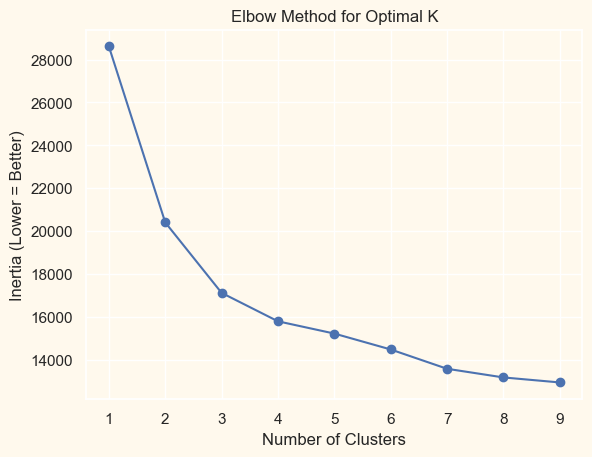

In [90]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, 'o-')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Lower = Better)")
plt.title("Elbow Method for Optimal K")
plt.show()

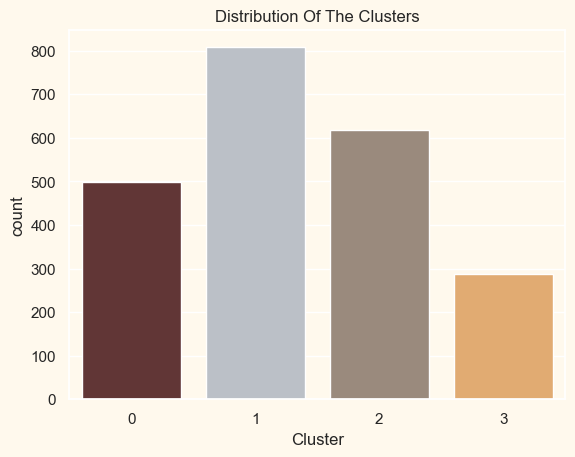

In [111]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(data=df, x="Cluster", hue="Cluster", palette=pal, legend=False)
pl.set_title("Distribution Of The Clusters")
plt.savefig('Distribution Of The Clusters.png')  # Save as PNG
plt.show()

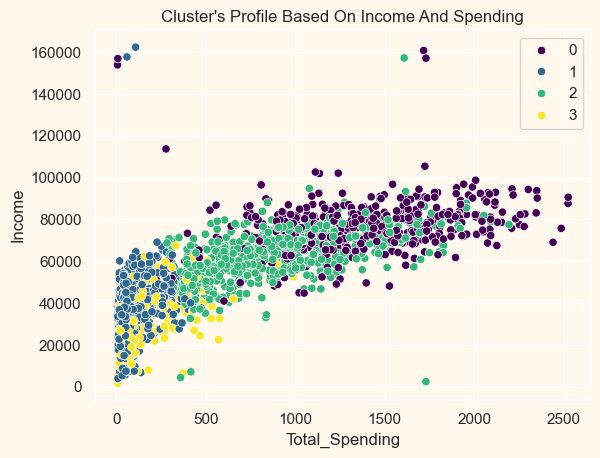

In [112]:
pl = sns.scatterplot(
    data=df,                # Pass the DataFrame here
    x="Total_Spending",     # Column name (no df[""])
    y="Income",             # Column name (no df[""])
    hue="Cluster",          # Column name (no df[""])
    palette="viridis"       # Or your chosen palette
)

pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.savefig('Cluster\'s Profile Based On Income And Spending.png')  # Save as PNG
plt.show()

In [93]:
import plotly.express as px
# Ensure kaleido is installed
!pip install -U kaleido

# Cluster distribution
fig = px.box(df,
             x='Cluster',  # Column with cluster labels (0,1,2)
             y='Total_Spending',  # Column with numerical values
             title='<b>Detailed Distribution of Clusters</b>',
             color='Cluster',  # Optional: color by cluster
             color_discrete_sequence=['#3498db', '#e74c3c', '#2ecc71'])
fig.update_layout(showlegend=False)
fig.show()

# Save the figure to a file (change filename to avoid overwriting)
fig.write_image("Detailed_Distribution_of_Clusters_1.png")

# If you want a second image with the same plot, change the filename
fig.write_image("Detailed_Distribution_of_Clusters_2.png")


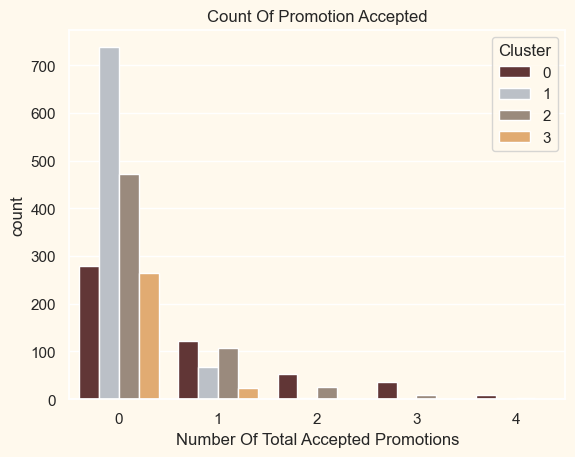

In [94]:
#Creating a feature to get a sum of accepted promotions 
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["Cluster"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

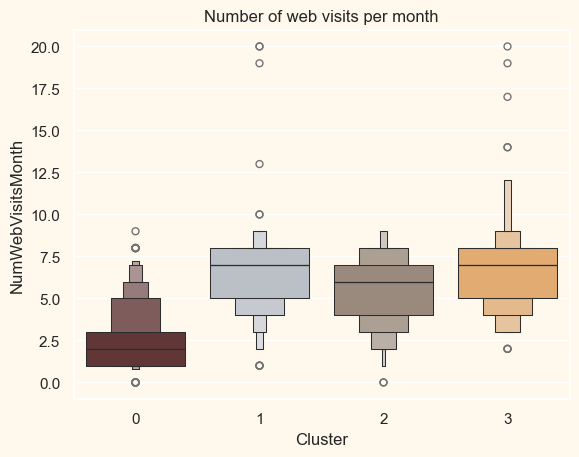

In [95]:
#Plotting the number of web visits per month
plt.figure()
pl=sns.boxenplot(y=df["NumWebVisitsMonth"],x=df["Cluster"], palette= pal)
pl.set_title("Number of web visits per month")
plt.show()

<Figure size 640x480 with 0 Axes>

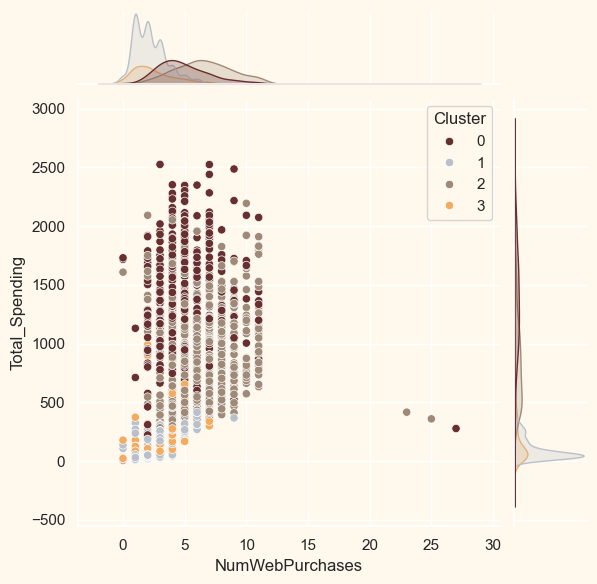

<Figure size 640x480 with 0 Axes>

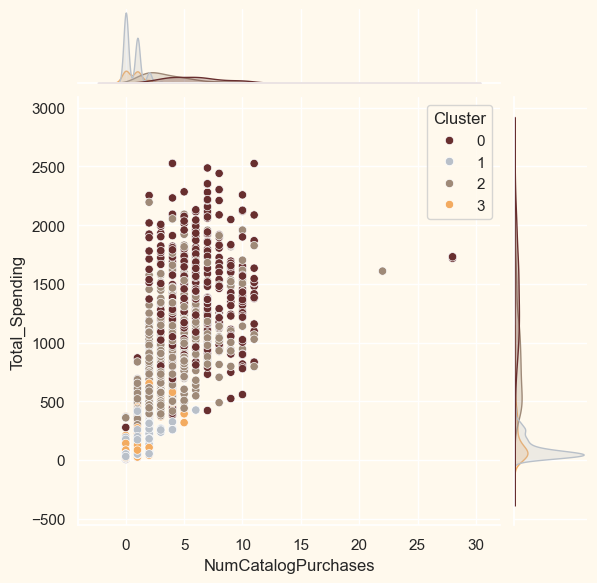

<Figure size 640x480 with 0 Axes>

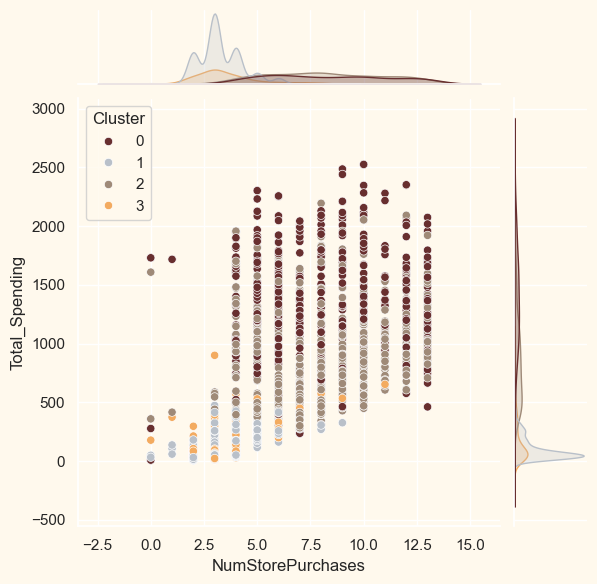

<Figure size 640x480 with 0 Axes>

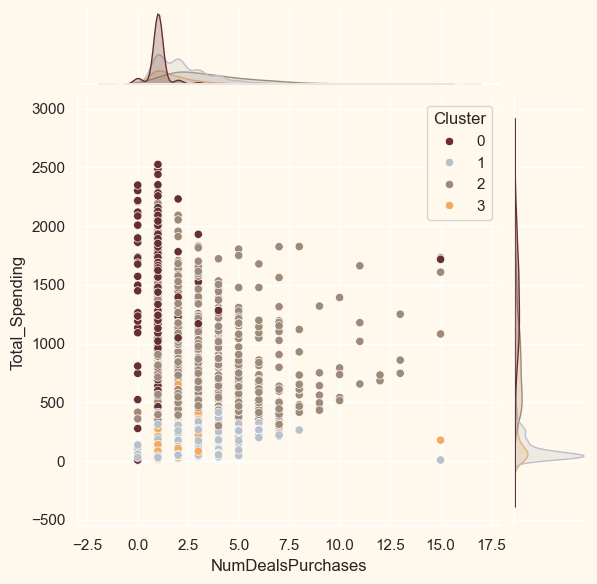

In [96]:
#for more details on the purchasing style 
Places =["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumDealsPurchases"] 

for i in Places:
    plt.figure()
    sns.jointplot(x=df[i],y = df["Total_Spending"],hue=df["Cluster"], palette= pal)
    plt.show()

<Figure size 640x480 with 0 Axes>

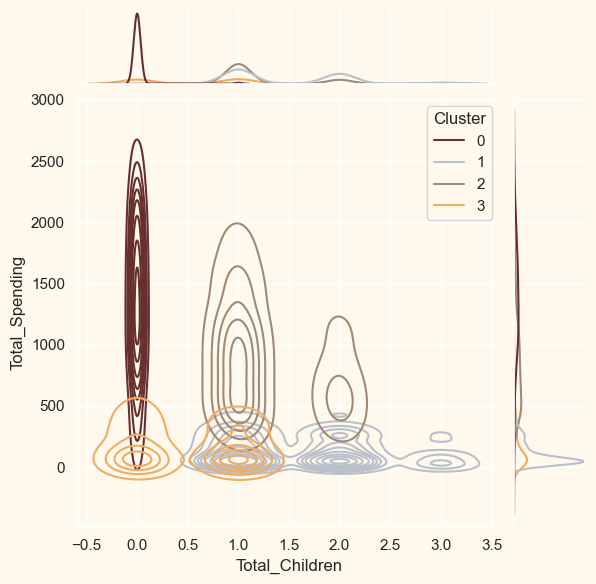

<Figure size 640x480 with 0 Axes>

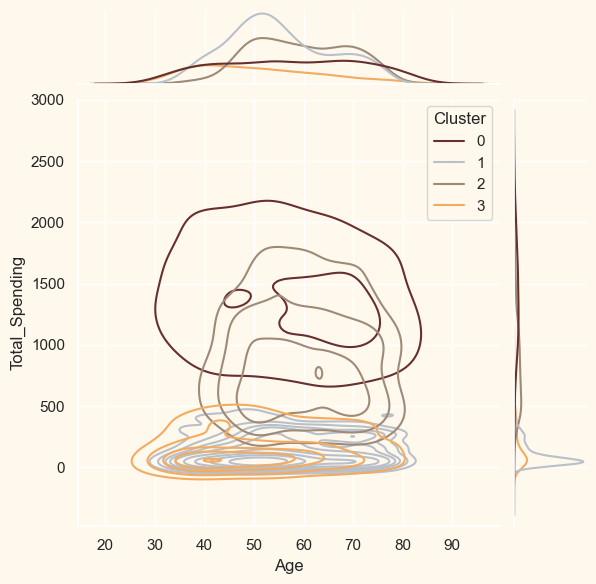

<Figure size 640x480 with 0 Axes>

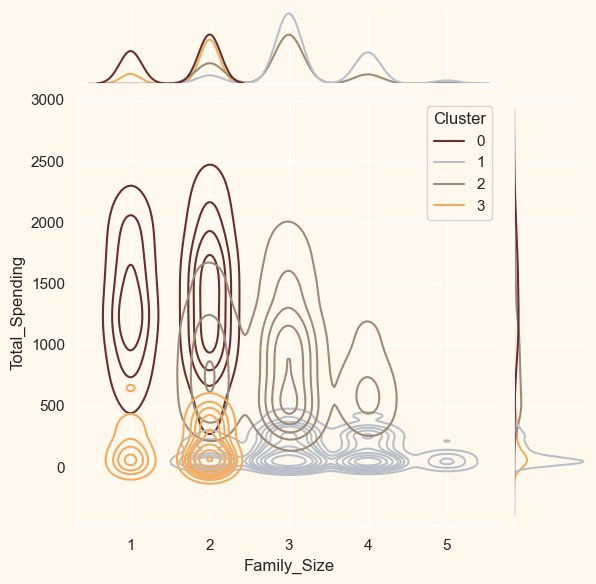

<Figure size 640x480 with 0 Axes>

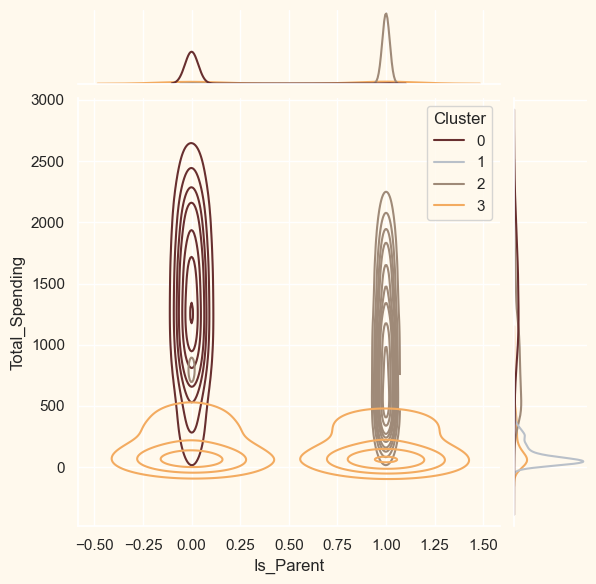

<Figure size 640x480 with 0 Axes>

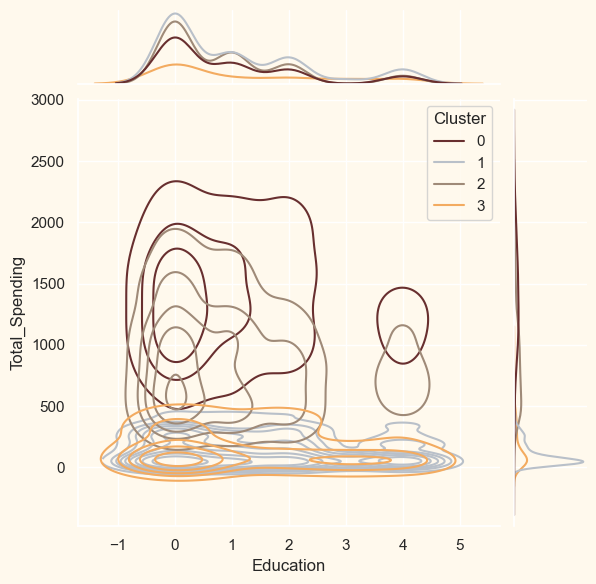

<Figure size 640x480 with 0 Axes>

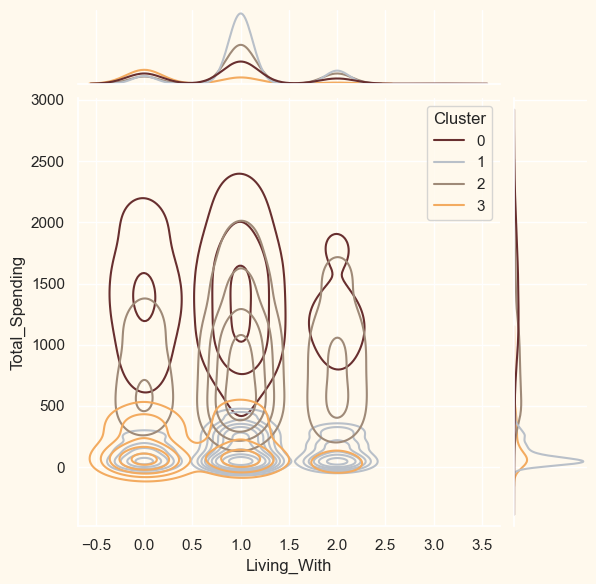

<Figure size 640x480 with 0 Axes>

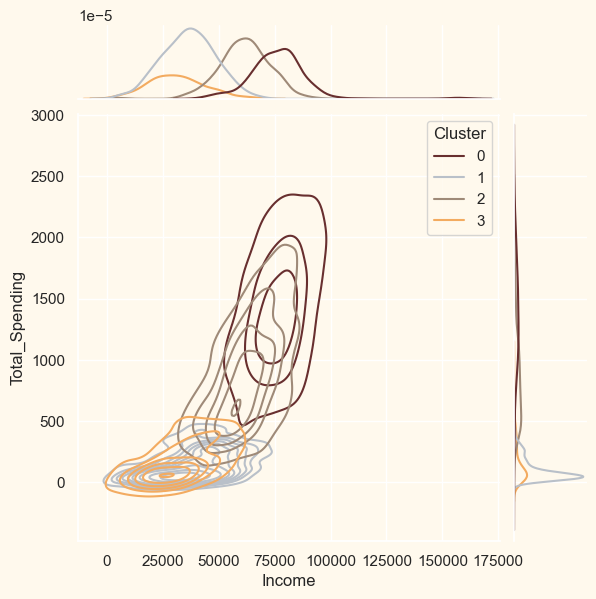

In [97]:
Personal = [ "Total_Children", "Age", "Family_Size", "Is_Parent", "Education", "Living_With", "Income"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Total_Spending"], hue =df["Cluster"], kind="kde", palette=pal)
    plt.show()

In [98]:
# Analyze Cluster Profiles

# 1. Select columns 
columns_needed = ["Total_Children", "Age", "Family_Size", "Total_Spending", 
                  "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumDealsPurchases", "NumWebVisitsMonth",
                 "Is_Parent", "Education", "Living_With", "Income", "Cluster"]
Personal = df[columns_needed]

# 2. Group by cluster and compute means
cluster_summary = Personal.groupby('Cluster').mean()

# 3. Display results
print(cluster_summary)  # For numerical features

         Total_Children        Age  Family_Size  Total_Spending  \
Cluster                                                           
0              0.014028  57.164329     1.601202     1366.096192   
1              1.487624  54.918317     3.259901      102.738861   
2              1.192869  59.354943     2.883306      865.064830   
3              0.524306  50.493056     1.819444      155.684028   

         NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
Cluster                                                            
0               4.921844             5.907816           8.246493   
1               2.210396             0.573020           3.301980   
2               6.609400             3.666126           8.153971   
3               2.510417             0.826389           3.576389   

         NumDealsPurchases  NumWebVisitsMonth  Is_Parent  Education  \
Cluster                                                               
0                 1.048096           2.597194 

In [99]:
# 1. Select columns 
columns_needed = ["Total_Children", "Age", "Family_Size", "Total_Spending", 
                  "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumDealsPurchases", "NumWebVisitsMonth",
                 "Is_Parent", "Education", "Living_With", "Income", "Cluster"]
Personal = df[columns_needed]

# 2. Group by cluster and compute medians
cluster_summary = Personal.groupby('Cluster').median()

# 3. Display results
print(cluster_summary)  # For numerical features

         Total_Children   Age  Family_Size  Total_Spending  NumWebPurchases  \
Cluster                                                                       
0                   0.0  56.0          2.0          1348.0              5.0   
1                   1.0  53.0          3.0            64.0              2.0   
2                   1.0  59.0          3.0           802.0              6.0   
3                   1.0  49.0          2.0            84.5              2.0   

         NumCatalogPurchases  NumStorePurchases  NumDealsPurchases  \
Cluster                                                              
0                        6.0                8.0                1.0   
1                        0.0                3.0                2.0   
2                        3.0                8.0                3.0   
3                        1.0                3.0                1.0   

         NumWebVisitsMonth  Is_Parent  Education  Living_With   Income  
Cluster                        

In [100]:
# 1. Select columns 
columns_needed = ["Total_Children", "Family_Size", 
                  "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumDealsPurchases", "NumWebVisitsMonth",
                 "Is_Parent", "Education", "Living_With", "Cluster"]
Personal = df[columns_needed]

# 2. Group by cluster and compute modes
cluster_summary = Personal.groupby('Cluster').apply(lambda x: x.mode().iloc[0])


# 3. Display results
print(cluster_summary)  # For numerical features

0        Total_Children  Family_Size  NumWebPurchases  NumCatalogPurchases  \
Cluster                                                                      
0                     0            2                4                    4   
1                     1            3                1                    0   
2                     1            3                6                    2   
3                     1            2                1                    0   

0        NumStorePurchases  NumDealsPurchases  NumWebVisitsMonth  Is_Parent  \
Cluster                                                                       
0                        6                  1                  2          0   
1                        3                  1                  7          1   
2                        8                  2                  6          1   
3                        3                  1                  7          1   

0        Education  Living_With  Cluster  
Cluster      

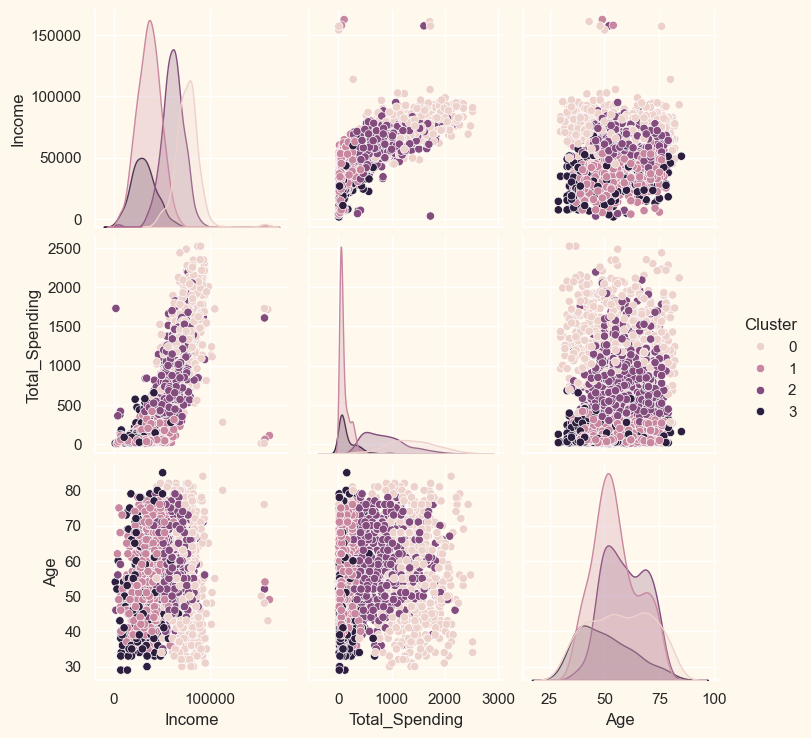

In [101]:
# Validation Steps
# Check for Overlaps:
# Compare pair plots of key features (e.g., Income vs. Total_Spending).

sns.pairplot(df, vars=['Income', 'Total_Spending', 'Age'], hue='Cluster')

In [102]:
# Assign Human-Readable Labels.
# Based on the averages, give each cluster a descriptive name.
cluster_labels = {
    0: "Affluent, Store-Centric Shoppers",
    1: "Budget-Conscious Large Families",
    2: "Active Omnichannel Shoppers",
    3: "Young, Price-Sensitive Browsers"
}
df['Segment'] = df['Cluster'].map(cluster_labels)

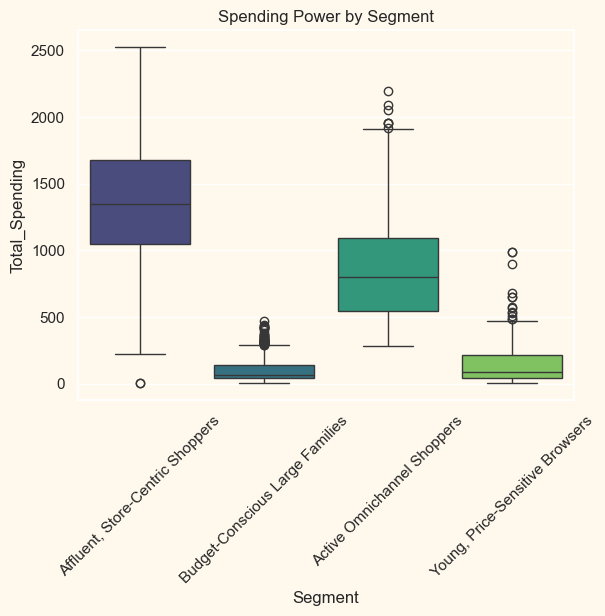

In [113]:
sns.boxplot(data=df, x='Segment', y='Total_Spending', hue='Segment', palette='viridis')
plt.xticks(rotation=45)
plt.title('Spending Power by Segment')
plt.savefig('Spending Power by Segment.png')  # Save as PNG
plt.show()

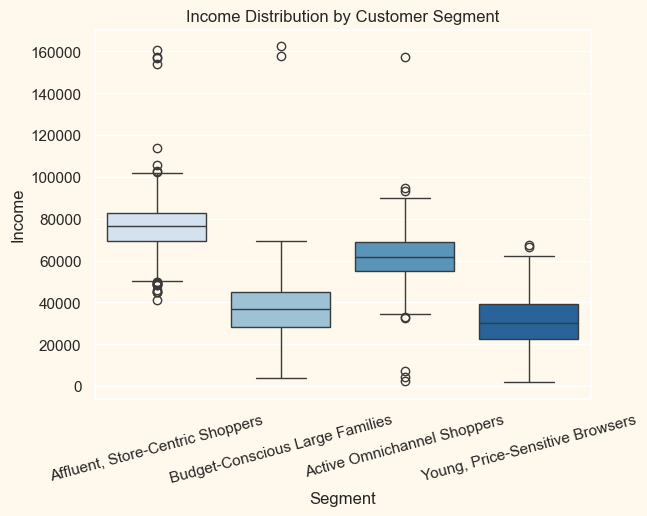

In [114]:
# Box plot for income distribution
sns.boxplot(data=df, x='Segment', y='Income', hue='Segment', palette='Blues')
plt.title('Income Distribution by Customer Segment')
plt.xticks(rotation=15)
plt.savefig('Income Distribution by Customer Segment.png')  # Save as PNG
plt.show()

In [105]:
conditions = [
    (df['Income'] < 40000) & (df['Total_Spending'] < 800),
    (df['Income'] > 75000) & (df['Total_Spending'] > 1500)
]

choices = ["Budget-Conscious", "Affluent Spenders"]
df['Cluster_Label'] = np.select(conditions, choices, default="Moderate Spenders")

In [106]:
fig = px.box(
    data_frame=df,  # ✅ Correct parameter name (not 'data')
    x='Cluster_Label', 
    y='Total_Spending',
    title='<b>Spending Distribution by Cluster</b>',
    color='Cluster_Label'  # Ensure this column exists in your DataFrame
)
fig.show()

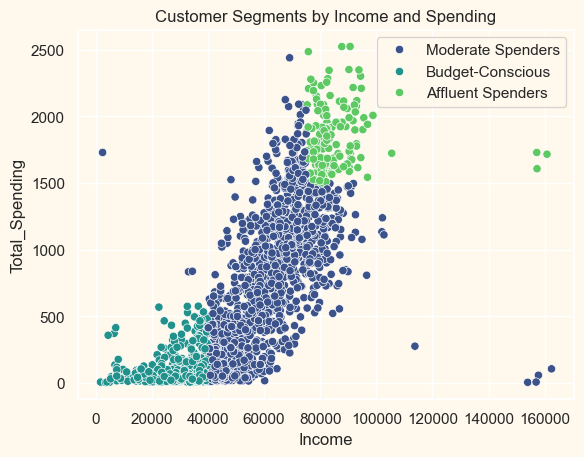

In [107]:
sns.scatterplot(data=df, 
                x='Income', 
                y='Total_Spending', 
                hue='Cluster_Label',
                palette='viridis')
plt.title('Customer Segments by Income and Spending')
plt.legend()
plt.show()

In [108]:
print(df[df['Cluster'] == 0].sample(10))  # Inspect random rows from Cluster 0

      Education   Income  Recency  NumDealsPurchases  NumWebPurchases  \
2012          0  96876.0       79                  1                7   
336           0  75693.0       10                  1               11   
976           2  82576.0       66                  1                2   
766           0  74985.0        8                  1                3   
996           0  75437.0       25                  1                8   
1883          2  62772.0       74                  1                5   
703           2  90247.0       27                  1                3   
240           0  73455.0       98                  1                6   
1363          4  52203.0       36                  1                8   
53            0  82582.0       54                  1                4   

      NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
2012                    7                  9                  2             0   
336                     4         

Cluster Analysis & Labeling
Based on the mean/median/mode statistics, we can derive distinct demographic and behavioral profiles for each cluster. Here’s how to interpret and label them:

1. Cluster 0: "Affluent Online Shoppers"
Key Traits:

Demographics:

Age: ~57 (oldest after Cluster 1).

Income: $75.6K (highest).

Family: Smallest households (1.6 avg size, 0 children).

Behavior:

Total Spending: $1,348 (highest).

Purchases: Prefers catalogs (5.9) and stores (8.2), but also shops online (4.9).

Deals: Rarely uses discounts (1.1 deals).

Web Visits: Low (2.6/month), suggesting efficient buying.

Label: "Affluent, Store-Centric Shoppers"

2. Cluster 1: "Large Families on a Budget"
Key Traits:

Demographics:

Age: ~61 (oldest).

Income: $42.3K (lowest).

Family: Largest households (3.6 avg size, 2 children).

Behavior:

Total Spending: $132 (lowest).

Purchases: Minimal catalog (0.8) and store (3.6) purchases.

Deals: Heavy deal usage (2.7 deals).

Web Visits: Highest (6.0/month), but low conversions.

Label: "Budget-Conscious Large Families"

3. Cluster 2: "Mid-Life High Spenders"
Key Traits:

Demographics:

Age: ~59.

Income: $61.7K (mid-range).

Family: Mid-sized (2.8 avg size, 1 child).

Behavior:

Total Spending: $873 (mid-range).

Purchases: Balances online (6.6) and store (8.2) shopping.

Deals: Moderate deal usage (3.6).

Web Visits: Frequent (5.5/month).

Label: "Active Omnichannel Shoppers"

4. Cluster 3: "Young Deal Hunters"
Key Traits:

Demographics:

Age: ~49 (youngest).

Income: $30K (lowest).

Family: Small-mid households (2.4 avg size, 1 child).

Behavior:

Total Spending: $99 (very low).

Purchases: Mostly online (2.2) and stores (3.1).

Deals: Frequent deal usage (1.8).

Web Visits: Highest (6.9/month), suggesting "window shopping".

Label: "Young, Price-Sensitive Browsers"